In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
%matplotlib notebook
from pathlib import Path
from noggin import create_plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib notebook
import pickle
import torch

from torch import nn
import torch.nn.functional as F

from detection_utils.boxes import non_max_suppression, generate_targets
from detection_utils.metrics import compute_recall, compute_precision
from detection_utils.pytorch import softmax_focal_loss
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mynn.layers.dropout import dropout
from mynn.activations.relu import relu
from mynn.initializers.glorot_uniform import glorot_uniform
from mygrad.nnet.layers import max_pool
from mygrad.nnet.losses import softmax_crossentropy
from mygrad.nnet.layers import conv_nd
from mynn.losses.cross_entropy import softmax_cross_entropy
from mynn.optimizers.adam import Adam
import numpy as np
import mygrad as mg
from mygrad import Tensor

from noggin import create_plot
import matplotlib.pyplot as plt

%matplotlib notebook


In [2]:
with open("indiv_labels.txt", mode = "r") as var:
        labels = var.read().splitlines()

In [3]:
def compute_detections(classifications, regressions, feature_map_width, anchor_box_step, anchor_box_size):
    """ Compute a set of boxes, class predictions, and foreground scores from
        detection model outputs.

    Parameters
    ----------
    classifications : torch.Tensor, shape=(N, R*C, # classes)
        A set of class predictions at each spatial location.

    regressions : torch.Tensor, shape=(N, R*C, 4)
        A set of predicted box offsets, in (x, y, w, h) at each spatial location.

    feature_map_width : int
        The number of pixels in the feature map, along the x direction.

    anchor_box_step : int
        The number of pixels (in image space) between each anchor box.

    anchor_box_size : int
        The side length of the anchor box.

    Returns
    -------
    Tuple[numpy.ndarray shape=(R*C, 4), numpy.ndarray shape=(R*C, 1), numpy.ndarray shape=(R*C,)]
        The (boxes, class predictions, foreground scores) at each spatial location.
    """
    
    #print(regressions)
    #print(regressions.shape)
    #print(len(regressions))
    
    box_predictions = np.empty((len(regressions), 4), dtype=np.float32)
    scores = torch.softmax(classifications, dim=-1).detach().cpu().numpy()
    scores = 1 - scores[:, 0]  # foreground score

    class_predictions = classifications.argmax(dim=-1, keepdim=True).detach().cpu().numpy()
    regressions = regressions.detach().cpu().numpy()

    y, x = np.divmod(np.arange(len(classifications)), feature_map_width, dtype=np.float32)
    x_reg, y_reg, w_reg, h_reg = regressions.T  # transform (R*C, 4) to (4, R*C) for assignment
    x = anchor_box_step * x + anchor_box_size * x_reg
    y = anchor_box_step * y + anchor_box_size * y_reg

    half_w = np.clip(np.exp(w_reg), 0, 10**6) * anchor_box_size / 2
    half_h = np.clip(np.exp(h_reg), 0, 10**6) * anchor_box_size / 2

    box_predictions[:, 0] = x - half_w  # x1
    box_predictions[:, 1] = y - half_h  # y1
    box_predictions[:, 2] = x + half_w  # x2
    box_predictions[:, 3] = y + half_h  # y2

    return box_predictions, class_predictions, scores

In [4]:
#Check this: temporary change
num_categories = 2
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        #Check this: the 3s-- kernel size
        
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.conv4 = nn.Conv2d(30, 40, (59,35))
        
        self.change = num_categories #used to be 4
        self.classification = nn.Conv2d(40, self.change, 1) # background / rectangle / triangle / circle
        self.regression = nn.Conv2d(40, 4, 1)
        
        for layer in (self.conv1, self.conv2, self.conv3, self.conv4,
                     self.classification, self.regression):
            nn.init.xavier_normal_(layer.weight, np.sqrt(2))
            nn.init.constant_(layer.bias, 0)

        nn.init.constant_(self.classification.bias[0], -4.6)  # rougly -log((1-π)/π) for π = 0.01
        
    def forward(self, x):
        
        #print("X")
        #print(x.shape)
        #print("Here3", F.max_pool2d(F.relu(self.conv1(x)), 2))
        #print()
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        #print(x.shape)
        
        #Check this:
        #print("x", x.shape)
        #print(self.classification(x).dtype)
        classifications = self.classification(x).permute(0, 2, 3, 1)                          # (N, R, C, # classes)
        classifications = classifications.reshape(x.shape[0], -1, classifications.shape[-1])  # (N, R*C, # classes)
        regressions = self.regression(x).permute(0, 2, 3, 1)                                  # (N, R, C, # classes)
        regressions = regressions.reshape(x.shape[0], -1, 4)                                  # (N, R*C, 4)
        return classifications, regressions

In [5]:
#Check this function
def crop_image(image, left, top):
    #print("image shape", image.shape)
    left = int(left)
    top = int(top)
    #assumes the dimensions of the resulting image should be 80X80
    return image[:, top:top+80,left:left+80]

In [6]:
#Check this: temporary change
class ClassifyingModel():
    def __init__(self):
        #Check this: the 3s-- kernel size
        gain = {'gain': np.sqrt(2)}
        
        self.conv1 = conv(3, 20, (5,5), weight_initializer=glorot_uniform, 
      weight_kwargs=gain)
        self.conv2 = conv(20, 10, (5,5), weight_initializer=glorot_uniform, 
      weight_kwargs=gain)
        
        #Check the dimensions on this:
        self.dense3 = dense(49000 , 232, weight_initializer=glorot_uniform, 
      weight_kwargs=gain)
        
    def __call__(self, x):
        ''' Forward data through the network.
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(N, D)
            The data to forward through the network.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 1)
            The model outputs.
        '''
        # returns output of dense -> relu -> dense -> relu -> dense -> softmax three layer.
        #print(x.shape)
        a = self.conv1(x)
        #print(a.shape)
        l = relu(max_pool(a,pool=(2,2), stride=1))
        #print(l.shape)
        b = max_pool(self.conv2(l), pool=(2,2),stride=1)
        #print(b.shape)
        s = b.shape
        #print(temp1.shape)
        b = b.reshape(s[0], s[1]*s[2]*s[3])
        #print(b.shape)
        #print(temp1.shape)
        return self.dense3(relu(b))
    
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        return self.conv1.parameters + self.conv2.parameters + self.dense3.parameters

In [7]:
#last known mean and std values: 200.62128, 42.149155 respectively
def scan_fridge(fridge_image, training_mean, training_std):
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    f = open("model7.p","rb")
    model = pickle.load(f)
    f.close()
    img = np.copy(fridge_image).astype(np.float32)
    img-=training_mean
    img/= training_std
    img = img[np.newaxis]
    img = torch.tensor(img.transpose(0, 3, 1, 2)).to(device)
    
    #print(img.shape)
    assert img.shape == torch.Size([1, 3,  800, 497]), "The fridge image is not in the right shape"
    
    out_cls, out_reg = model(img)
    box_preds, class_preds, scores = compute_detections(out_cls.squeeze(), 
                                                        out_reg.squeeze(), 
                                                        feature_map_width=13,
                                                        anchor_box_step=40, 
                                                        anchor_box_size=80)
    #Check this
    threshold = 0
    keep = scores > threshold
    box_preds = box_preds[keep]
    class_preds = class_preds[keep]
    scores = scores[keep]
    keep_idxs = non_max_suppression(box_preds, scores, threshold=0.1)
    box_preds = box_preds[keep_idxs]
    class_preds = class_preds[keep_idxs]
    #print(box_preds)
    food_images = []
    food_coords = []
    
    
    for class_pred, box_pred in zip(class_preds, box_preds):
        if class_pred > 0:
            x1, y1, x2, y2 = box_pred
            if x1 < 0 or y1 < 0 or x2 >= 497 or y2 >= 800:
                continue
            cropped_image = crop_image(fridge_image.swapaxes(0,2).swapaxes(1,2),x1,y1)
            #print("cropped image shape", cropped_image.shape)
            food_images.append(cropped_image)
            food_coords.append((x1,y1))
    #print("one item in food_images", food_images[2].shape)
    #print("coords", food_coords)
    food_images = np.array(food_images)
    #print("all images shape", food_images.shape)
    if len(food_images)==0:
        return []
    #print(food_images.shape, food_images)
    f = open("classifying_model2.p", "rb")
    classifying_model = pickle.load(f)
    f.close()
    classes = classifying_model(food_images)
    
    #print(classes.shape)
    #print(food_coords[0][0])
    #print(food_coords[0][1])
    #print(labels[np.argmax(classes[0].flatten())])
    
    return food_images, [(food_coords[i][0], food_coords[i][1], labels[np.argmax(classes[i].flatten())], "food") for i in range(len(classes))]
    #Check this: CHANGE back to this LATER
    #return [Item(food_coords[i][0], food_coords[i][1], labels[classes[i]], "food")for i in range(len(classes))]
    

In [9]:
"""f = open("classifying_model2.p", "rb")
classifying_model = pickle.load(f)
f.close()
randInd = np.random.randint(0,232)
print(randInd)
print(labels[randInd])
classes = classifying_model(images[randInd].swapaxes(0,2).swapaxes(1,2)[np.newaxis])
print(labels[np.argmax(classes[0].flatten())])
"""


'f = open("classifying_model2.p", "rb")\nclassifying_model = pickle.load(f)\nf.close()\nrandInd = np.random.randint(0,232)\nprint(randInd)\nprint(labels[randInd])\nclasses = classifying_model(images[randInd].swapaxes(0,2).swapaxes(1,2)[np.newaxis])\nprint(labels[np.argmax(classes[0].flatten())])\n'

[(212.40688, 158.97057, 'veggie burger', 'food'), (30.008518, 173.82333, 'olives', 'food'), (100.994606, 171.42047, 'fish sticks', 'food'), (275.4599, 185.43991, 'coke', 'food'), (350.26743, 172.48616, 'can of beans', 'food'), (107.39321, 293.07184, 'donut', 'food'), (205.64194, 287.3332, 'veggie burger', 'food'), (293.33795, 290.16904, 'peanut', 'food'), (21.46312, 285.5024, 'romaine lettuce', 'food'), (351.7137, 303.26822, 'coke', 'food'), (198.60391, 424.43643, 'muffin', 'food'), (332.3224, 410.65057, 'romaine lettuce', 'food'), (3.059475, 409.02115, 'waffle', 'food'), (102.070496, 423.86542, 'broccoli', 'food'), (209.6129, 517.68353, 'gummy', 'food'), (26.359894, 549.1381, 'green juice', 'food'), (105.24284, 536.33, 'green juice', 'food'), (336.14386, 550.6975, 'celery', 'food'), (10.28574, 696.8731, 'broccoli', 'food'), (96.92703, 685.4743, 'gummy', 'food'), (173.91566, 695.36066, 'chicken wings', 'food'), (273.53552, 688.7379, 'kiwi', 'food'), (374.04846, 683.0082, 'fish', 'food'

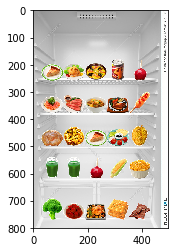

In [23]:
#TESTING ONLY:
#last known mean and std values: 200.62128, 42.149155 respectively
fridge, not_using, not_using2 = generate_fridge(np.random.randint(0,26))
food_images, res = scan_fridge(fridge, 200.62128, 42.149155)
print(res)

(10.28574, 696.8731, 'broccoli', 'food')


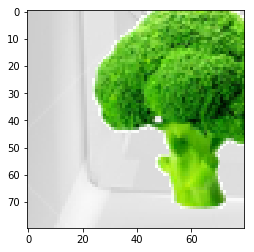

In [40]:
randInd = np.random.randint(0,len(food_images))
print(res[randInd])
plt.imshow(food_images[randInd].swapaxes(1,2).swapaxes(0,2))

In [8]:

def layer_image(background, roi_image, image, shift = (0,0)):
    ''' Replaces the pixels of the foreground with the pixels of the colored image
    wherever the image region is true.
    
    Parameters
    ----------
    background : numpy.array of shape (M,N,3)
    
    roi_image : numpy.array of shape (X,Y,3) where X and Y are <= M and N.
                Elements are 1 where the object region is detected and 0 where it is not.
    
    image : numpy.array of shape (X,Y,3).
            Elements are the color of the image
    
    shift : Tuple(int, int)
                The amount of shift (down, right) from (0,0), or top left, of the background
        
    Returns
    -------
    Numpy.array of shape (M,N,3)
        Altered background array
    '''
    shift_down, shift_right = shift
    for i in range(roi_image.shape[0]):
        for j in range(roi_image.shape[1]):
            if roi_image[i][j] == 1:
                background[i + shift_down][j + shift_right] = image[i][j]
    return background

def propose_regions(image, threshold=0.1):
    ''' Create binary region predictions from an image.
    
    Parameters
    ----------
    image : numpy.ndarray, shape=(R, C, 3)
        The image for which to propose regions.
        
    threshold : Real ∈ [0, 1], optional (default=0.1)
        The color threshold at which to propose regions.
        
    Returns
    -------
    numpy.ndarray, shape=(R, C)
        The binary image holding regions of interest.
    '''
    
    roi_img = np.zeros(image.shape[:2], dtype=np.uint8) # shape (R, C)
    
    # regions of interest (RoIs) are where the maximum RGB difference across a single
    # pixel location is at least 0.1
    
    # get the color vector differences by taking (R, C, 3, 1) - (R, C, 1, 3)
    diffs = np.abs(image[..., np.newaxis] - image[:, :, np.newaxis, :])
    
    # find where the color difference is > 0.1
    rois = np.where(np.max(diffs, axis=(2, 3)) > 0.1)
    
    # those areas are foreground (objects)
    roi_img[rois] = 1
    return roi_img

rgba_image = mpimg.imread('food.png')

rgba_pil = PIL.Image.open('food.png')
img = np.array(rgba_pil.convert('RGB'))

row_step = 1200//15
col_step= 1280//16
shelf_coord = [260, 380, 500, 620, 770] 

images = []
for i in range(0, 1200, row_step):
    for j in range(0, 1280, col_step):
        images.append(img[i: i + row_step, j : j + col_step, :])
images = images[:-8]

fridge = mpimg.imread('fridge.jpg')
fridge = np.array(fridge)
roi_images = [propose_regions(i) for i in images]


def parse_food():


    rgba_pil = PIL.Image.open('food.png')
    img = np.array(rgba_pil.convert('RGB'))

    row_step = 1200 // 15
    col_step = 1280 // 16

    images = [] #list of each image's rgb arrays
    labels = [] #list of each image's label

    for i in range(0, 1200, row_step):
        for j in range(0, 1280, col_step):
            images.append(img[i: i + row_step, j: j + col_step, :])
            #CHANGE THIS, Check this:
            labels.append("X")

    images = np.array(images[:-8]) #takes out the random lack of food at last row
    # list of each regionized image where 1 indicates object and 0 indicates background
    roi_images = np.array([propose_regions(i) for i in images])

    #All labels defined above
    return images, roi_images, labels

image_width = 80
image_height = 80
def generate_fridge(num_items):
    """
    num_items >=0 && <=25a
    """

    images, roi_images, labels = parse_food()
    right = [shift for shift in range(30, 400, 80)]
    shelf_coord = [180, 300, 420, 540, 690]  # coordinates of the first, second ... shelves
    shift_ls = []
    for shelf in shelf_coord:
        for pos in right:
            shift_ls.append([(shelf, pos)])
    
    fridge = mpimg.imread('fridge.jpg')
    fridge = np.array(fridge)
    
    boxes_list = []
    labels_list = []
    
    for i in range(num_items):
        #rand_shelf = shelf_coord[np.random.randint(0, len(shelf_coord))]
        randint = np.random.randint(0, len(images))
        #rand_image = images[np.random.randint(0, len(images))]
        shift = shift_ls.pop(np.random.randint(0, len(shift_ls))) #random right shift
        fridge = layer_image(fridge, roi_images[randint], images[randint], shift[0])
        boxes_list.append(np.array([shift[0][1], shift[0][0], shift[0][1]+image_width, shift[0][0]+image_height], dtype=np.float32))
        labels_list.append(np.array(labels[randint]))
    boxes_list = np.vstack(boxes_list)   
    plt.imshow(fridge)
    return fridge,boxes_list,np.array(labels_list)
